In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [66]:
es = pd.read_csv('ES.csv', parse_dates=['date'])
es = es.set_index('date').sort_index()
es_4h = es['log_ret'].resample('4h').sum().to_frame('log_ret')
es_4h['log_ret'].value_counts()
data_gc = es_4h.loc[~(es_4h['log_ret'] == 0)].copy()

In [67]:
gc = pd.read_csv('GC.csv', parse_dates = ['date'])
gc = gc.set_index('date').sort_index()
gc_4h = gc['log_ret'].resample('4h').sum().to_frame('log_ret')
gc_4h['log_ret'].value_counts()
data_gc = gc_4h.loc[~(gc_4h['log_ret'] == 0)].copy()

In [114]:
df = pd.read_csv('NQ.csv', parse_dates=['date'])
df = df.set_index('date').sort_index()

df_4h = df['log_ret'].resample('4h').sum().to_frame('log_ret')

data = df_4h.loc[~(df_4h['log_ret'] == 0)].copy()

def make_features(data):
    X = pd.DataFrame(index=data.index)

    for lag in [1, 3, 5, 10]:
        X[f'lag_{lag}'] = data['log_ret'].shift(lag)

    X['std_3']  = data['log_ret'].rolling(3).std()
    X['rolling_std_5'] = data['log_ret'].rolling(5).std()
    X['z_score'] = data['log_ret'] / (X['rolling_std_5'] + 1e-8)
    X['log_ret_squared'] = data['log_ret']**2
    X['sign'] = np.sign(data['log_ret'])
    
    # roll_std = data['log_ret'].rolling(window = 20).std()
    # roll_mean = data['log_ret'].rolling(window = 20).mean()
    # X['rolling_sharpe'] = roll_mean / roll_std * np.sqrt(20)

    # downside = data['log_ret'].copy()
    # downside[data['log_ret'] > 0]
    # down_std = downside.rolling(window = 20).std()
    # X['rolling_sortino'] = roll_mean / down_std * np.sqrt(20)

    am = arch_model(data['log_ret'] * 100, vol='GARCH', p=1, q=1, dist='normal')
    res = am.fit(disp='off')
    X['garch_vol'] = res.conditional_volatility / 100

    X['gc'] = gc_4h['log_ret']
    X['es'] = es_4h['log_ret']
    # X['price'] = 1.0 * np.exp(data['log_ret'].cumsum())

    X['hour'] = data.index.hour
    X['day'] = data.index.day
    X['weekday'] = data.index.weekday
    X['month'] = data.index.month

    P = 24/4  
    t = np.arange(len(X))
    X['sin_2pi_t_P'] = np.sin(2 * np.pi * t / P)
    X['cos_2pi_t_P'] = np.cos(2 * np.pi * t / P)

    X['absRet'] = np.abs(data['log_ret'])
    # X['EmaAbsRet'] = X['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    # X['vol'] = X['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    vol = data['log_ret'].abs().ewm(span=20).mean().ewm(span=200).mean()
    X['nr'] = data['log_ret'] / (vol + 1e-8)

    # delta = X['price'].diff()
    # gain, loss = delta.clip(lower=0), -delta.clip(upper=0)
    # roll_up = gain.ewm(span=14).mean()
    # roll_down = loss.ewm(span=14).mean()
    # X['rsi_14'] = 100 - 100/(1 + roll_up/(roll_down+1e-8))

    # X['ma20'] = X['price'].rolling(20).mean()
    # X['std20'] = X['price'].rolling(20).std()
    # X['bb_upper'] = X['ma20'] + 2*X['std20']
    # X['bb_lower'] = X['ma20'] - 2*X['std20']

    # ema12 = X['price'].ewm(span=12).mean()
    # ema26 = X['price'].ewm(span=26).mean()
    # X['macd'] = ema12 - ema26
    # X['macd_signal'] = X['macd'].ewm(span=9).mean()

    # X['skew_10'] = data['log_ret'].rolling(10).skew()
    # X['kurt_10'] = data['log_ret'].rolling(10).kurt()
    # X['q90_30'] = data['log_ret'].rolling(30).quantile(0.9)

    return X.dropna()

features = make_features(data)

y = features['nr'].values
X = features.drop(columns=['nr']).values

n = len(X)
i1 = int(0.6 * n)
i2 = int(0.8 * n)

X_train, y_train = X[:i1], y[:i1]
X_val, y_val = X[i1:i2], y[i1:i2]
X_test, y_test = X[i2:], y[i2:]

feat_train = features.iloc[:i1]
feat_val = features.iloc[i1:i2]
feat_test = features.iloc[i2:]

In [ ]:
def objective(trial):
    # Определяем гиперпараметры для подбора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0),
        'loss_function': 'RMSE',
        'logging_level': 'Silent'
    }
    # Обучаем модель с ранней остановкой
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True)
    
    # Делим предикты на историческое σ для сигнала
    scale = np.std(model.predict(X_train)) + 1e-6
    raw = model.predict(X_val) / scale
    
    # Генерируем позиции по порогам
    pos = np.where(raw >  0.7, 1,
           np.where(raw < 0.3, -1, 0))
    
    # Рассчитываем PnL на валидации и Sharpe ratio
    slippage = 1e-5
    ret_val = data['log_ret'].loc[feat_val.index].values
    pnl = ret_val * pos - slippage * np.abs(np.diff(np.concatenate([[0], pos])))
    daily_pnl = pd.Series(pnl, index=feat_val.index).resample('1D').sum()
    sharpe = daily_pnl.mean() / (daily_pnl.std() + 1e-9) * np.sqrt(252)
    
    return sharpe

# Создаём и запускаем исследование
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar = True)

# Лучшие параметры
best_params = study.best_params
print("Best params:", study.best_params)



[I 2025-04-23 17:29:25,152] A new study created in memory with name: no-name-34d4767d-2bc7-4b86-b330-0ec5356cef70


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_4746/2392333497.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_4746/2392333497.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_4746/2392333497.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-04-23 17:29:25,554] Trial 0 finished with value: 17.94230767605633 and parameters: {'iterations': 497, 'depth': 5, 'learning_rate': 0.04050842688068961, 'l2_leaf_reg': 0.46004581626334157, 'random_strength': 0.022759565708139518}. Best is trial 0 with value: 17.94230767605633.
[I 2025-04-23 17:29:25,924] Trial 1 finished with value: 18.02152289991782 and parameters: {'iterations': 763, 'depth': 3, 'learning_rate': 0.042599358448318615, 'l2_leaf_reg': 4.1310619982343635, 'random_strength': 0.0017668148330598184}. Best is trial 1 with value: 18.02152289991782.
[I 2025-04-23 17:29:26,335] Trial 2 finished with value: 18.383756443580133 and parameters: {'iterations': 591, 'depth': 5, 'learning_rate': 0.00463294365574445, 'l2_leaf_reg': 0.04762358694265847, 'random_strength': 0.004216443510827195}. Best is trial 2 with value: 18.383756443580133.
[I 2025-04-23 17:29:26,508] Trial 3 finished with value: 18.49861610099514 and parameters: {'iterations': 167, 'depth': 6, 'learning_rate':

In [ ]:
best_params = {
    'iterations': 500,
    'depth': 4,
    'learning_rate': 0.05,
    'l2_leaf_reg': 5,
    'random_strength': 1.0,
    'loss_function': 'RMSE',
    'logging_level': 'Silent'
}
model = CatBoostRegressor(**best_params)
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

# 6. Предикт на тесте и формирование сигналов
preds_test = model.predict(X_test)
scale = np.std(model.predict(X_train)) + 1e-6
raw = preds_test / scale

# Порог >0.7 → лонг; <0.3 → шорт; иначе flat
pos = np.where(raw > 0.7,  1,
      np.where(raw < 0.3, -1, 0))

# Помещаем в DataFrame с нужным индексом
feat_test = feat_test.copy()
feat_test['position'] = pos

# 7. Рассчитываем PnL и equity curve
slippage = 1e-5
# Берём log_ret точно по тем же 4H-меткам
ret_test_4h = data['log_ret'].loc[feat_test.index]

pnl = (ret_test_4h * feat_test['position']
     - slippage * feat_test['position'].diff().abs()).fillna(0)

# Переводим в дневной вид для сравнения
equity = pnl.resample('1D').sum().cumsum()
bh     = data['log_ret'].resample('1D').sum().cumsum()

# 8. График
plt.figure(figsize=(10,5))
plt.plot(equity, label='strategy (test)')
plt.plot(bh,     label='buy & hold (test)')
plt.axvline(equity.index[0], color='gray', linestyle='--')  # начало теста
plt.legend()
plt.title('Test performance')
plt.show()

In [ ]:
# from catboost import CatBoostClassifier
# import numpy as np

# y_train_cls = (y_train > 0).astype(int)
# y_val_cls   = (y_val   > 0).astype(int)

# print(np.unique(y_train_cls), np.unique(y_val_cls)) 

# model = CatBoostClassifier(
#     iterations=500,
#     eval_metric='AUC',
#     early_stopping_rounds=50,
#     use_best_model=True,
#     verbose=10
# )

# model.fit(
#     X_train, y_train_cls,
#     eval_set=(X_val, y_val_cls)
# )

# best_iter    = model.get_best_iteration()
# best_val_auc = model.get_best_score()['validation']['AUC']
# print(f"Лучший AUC на валидации = {best_val_auc:.4f} (итерация {best_iter})")

# from sklearn.metrics import roc_auc_score
# init_prob = np.repeat(y_train_cls.mean(), len(y_val_cls))
# print("Init AUC manually:", roc_auc_score(y_val_cls, init_prob))


[0 1] [0 1]
Learning rate set to 0.067363
0:	test: 1.0000000	best: 1.0000000 (0)	total: 1.59ms	remaining: 794ms
10:	test: 1.0000000	best: 1.0000000 (0)	total: 14.1ms	remaining: 626ms
20:	test: 1.0000000	best: 1.0000000 (0)	total: 26.8ms	remaining: 611ms
30:	test: 1.0000000	best: 1.0000000 (0)	total: 38.7ms	remaining: 586ms
40:	test: 1.0000000	best: 1.0000000 (0)	total: 51.3ms	remaining: 574ms
50:	test: 1.0000000	best: 1.0000000 (0)	total: 63.8ms	remaining: 562ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.
Лучший AUC на валидации = 1.0000 (итерация 0)
Init AUC manually: 0.5


Final return: 1094.2562
Annualized Sharpe: 22.32


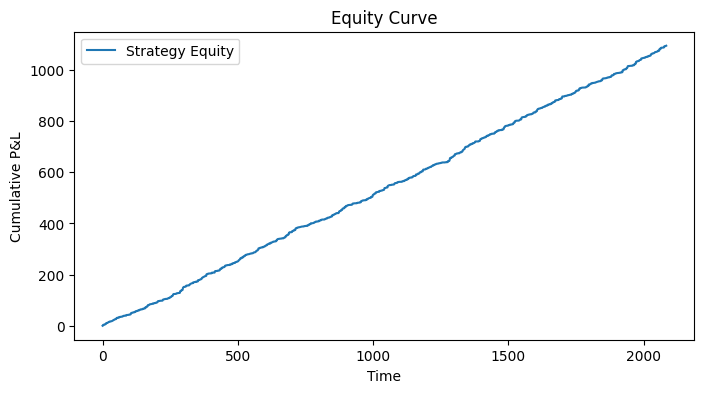

In [ ]:
# y_pred_test = model.predict(X_test)

# pos = np.sign(y_pred_test)  # для регрессии: +1 если ŷ>0, −1 если ŷ<0

# rets_test = y_test  

# # 4) P&L стратегии
# slippage = 0.0005
# delta_pos = np.abs(np.diff(np.concatenate([[0], pos])))
# pnl = pos * rets_test - slippage * delta_pos

# # 5) Кумулятивная доходность
# equity = np.cumsum(pnl)

# # 6) Итоговые показатели
# final_return = equity[-1]
# sharpe = (pnl.mean() / (pnl.std() + 1e-9)) * np.sqrt(252 * (24/4))

# print(f"Final return: {final_return:.4f}")
# print(f"Annualized Sharpe: {sharpe:.2f}")

# # 7) Визуализация
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8,4))
# plt.plot(equity, label='Strategy Equity')
# plt.title('Equity Curve')
# plt.xlabel('Time')
# plt.ylabel('Cumulative P&L')
# plt.legend()
# plt.show()


In [86]:
feat_test['position'].value_counts()

position
-1    989
 1    693
 0    402
Name: count, dtype: int64

Learning rate set to 0.067363
0:	test: 1.0000000	best: 1.0000000 (0)	total: 2.15ms	remaining: 1.07s
1:	test: 1.0000000	best: 1.0000000 (0)	total: 3.25ms	remaining: 810ms
2:	test: 1.0000000	best: 1.0000000 (0)	total: 4.93ms	remaining: 816ms
3:	test: 1.0000000	best: 1.0000000 (0)	total: 6.71ms	remaining: 832ms
4:	test: 1.0000000	best: 1.0000000 (0)	total: 8.43ms	remaining: 834ms
5:	test: 1.0000000	best: 1.0000000 (0)	total: 10.4ms	remaining: 855ms
6:	test: 1.0000000	best: 1.0000000 (0)	total: 11.8ms	remaining: 829ms
7:	test: 1.0000000	best: 1.0000000 (0)	total: 13ms	remaining: 799ms
8:	test: 1.0000000	best: 1.0000000 (0)	total: 14.4ms	remaining: 783ms
9:	test: 1.0000000	best: 1.0000000 (0)	total: 15.8ms	remaining: 776ms
10:	test: 1.0000000	best: 1.0000000 (0)	total: 17ms	remaining: 757ms
11:	test: 1.0000000	best: 1.0000000 (0)	total: 18.2ms	remaining: 742ms
12:	test: 1.0000000	best: 1.0000000 (0)	total: 19.6ms	remaining: 733ms
13:	test: 1.0000000	best: 1.0000000 (0)	total: 20.8ms	remaini

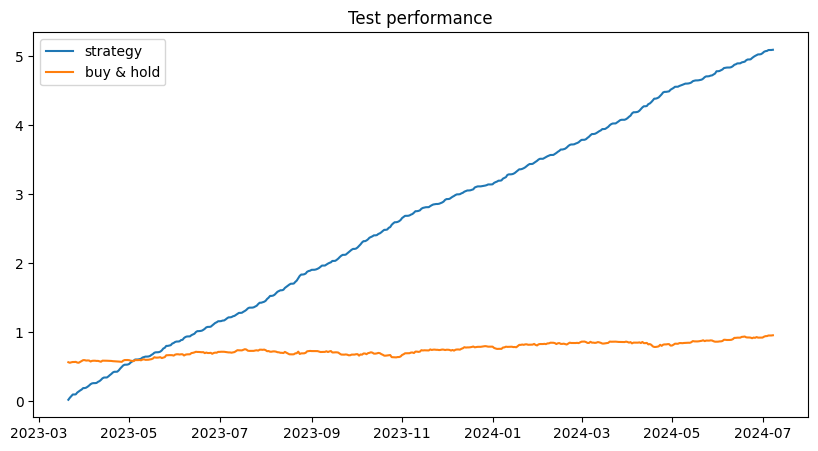

In [ ]:
# from catboost import CatBoostClassifier

# model = CatBoostClassifier(
#     iterations=500,
#     loss_function='Logloss',
#     eval_metric='AUC'
# )
# model.fit(X_train, (y_train>0).astype(int), eval_set=(X_val, (y_val>0).astype(int)))
# preds_test = model.predict(X_test)
# scale = np.std(model.predict(X_train)) + 1e-6
# raw = preds_test / scale

# thr = 0.7
# pos = np.where(raw > thr,  1,
#       np.where(raw < 1-thr, -1, 0))

# feat_test = feat_test.copy()
# feat_test['position'] = pos

# slippage = 1e-5

# ret_test_4h = data['log_ret'].loc[feat_test.index]

# pnl = (ret_test_4h * feat_test['position'] - slippage * feat_test['position'].diff().abs()).fillna(0)

# equity = pnl.resample('1D').sum().cumsum()
# bh = data['log_ret'].resample('1D').sum().cumsum()

# start_test = feat_test.index[0]
# equity_test = equity.loc[start_test:]
# bh_test = bh.loc[start_test:]

# plt.figure(figsize=(10,5))
# plt.plot(equity_test, label='strategy')
# plt.plot(bh_test, label='buy & hold')
# plt.legend()
# plt.title('Test performance')
# plt.show()



In [87]:
daily_vol = equity.std()
annual_vol = daily_vol * np.sqrt(252)

print(f"Daily volatility: {daily_vol:.6f}")
print(f"Annualized volatility: {annual_vol:.6f}")

daily_mean = equity.mean()
annual_return = daily_mean * 252

print(f"Daily mean return: {daily_mean:.6f}")
print(f"Annualized return: {annual_return:.6f}")

sharpe = annual_return / annual_vol
print(f"Sharpe ratio (annualized): {sharpe:.2f}")


Daily volatility: 1.413482
Annualized volatility: 22.438338
Daily mean return: 2.534012
Annualized return: 638.571001
Sharpe ratio (annualized): 28.46


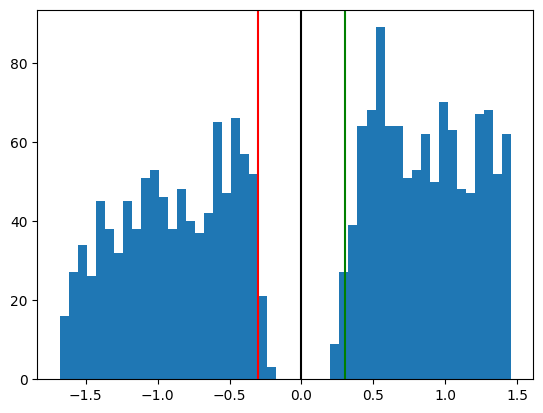

In [88]:
plt.hist(raw, bins=50)
plt.axvline(0, color='k')
plt.axvline( 0.3, color='g')
plt.axvline(-0.3, color='r')
plt.show()


=== Train ===
RMSE : 1.459576181542473
MAE  : 0.9046769730983701
R2   : 0.12304102121243099 

=== Val ===
RMSE : 1.469884706121965
MAE  : 0.9027350260945285
R2   : 0.13207897098172006 

=== Test ===
RMSE : 1.3719635766403953
MAE  : 0.8661815085664252
R2   : 0.12687653206661853 



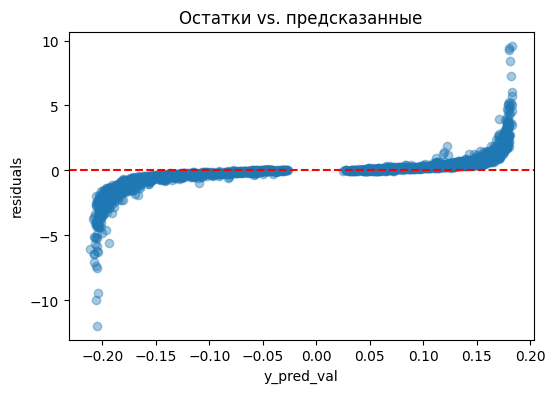

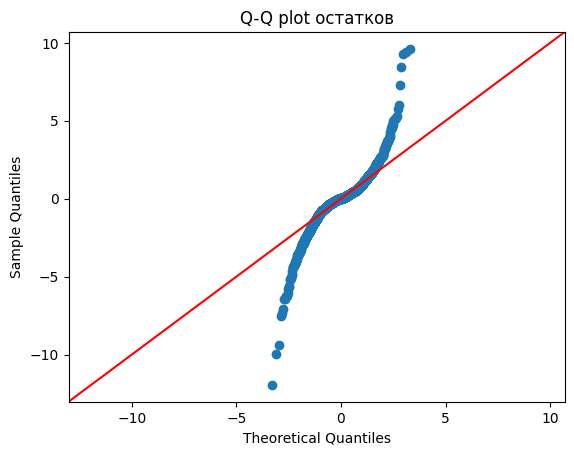

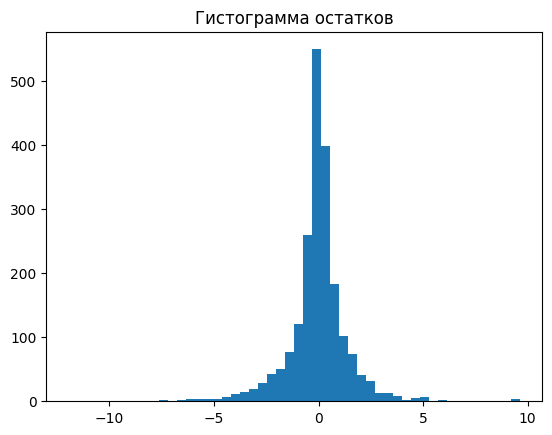

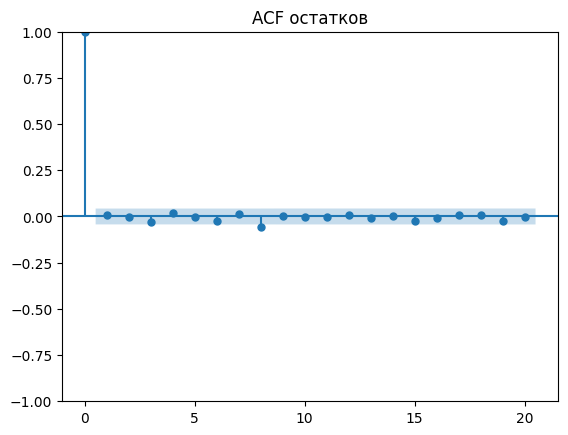

Shapiro–Wilk (нормальность): ShapiroResult(statistic=np.float64(0.8678189561550749), pvalue=np.float64(8.887653800491854e-39))
Durbin–Watson (автокорреляция): 1.97992039159942
Breusch–Pagan: {'Lagrange multiplier': np.float64(1721.2899730351974), 'p-value': np.float64(0.0)}
Ljung–Box (lag=10):
       lb_stat  lb_pvalue
10  10.639409   0.386292

TimeSeriesSplit CV RMSE scores: [1.44342048 1.46375051 1.60549166 1.35584345 1.33762142]
>>> ADF test:
ADF p-value = 0.000

>>> KPSS test:
KPSS p-value = 0.100

>>> Engle’s ARCH test:
ARCH p-value = 0.000

>>> Runs test (рандомность):
Runs test p-value = 0.091


/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_3542/3904246317.py:100: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(rets.dropna(), regression='c')


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.sandbox.stats.runs import runstest_1samp
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Обучаем модель на train
model = CatBoostRegressor(**best_params, verbose=False)
model.fit(X_train, y_train)

# 2) Предсказания и остатки
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

res_train = y_train - y_pred_train
res_val   = y_val   - y_pred_val

# 3) Основные метрики
for name, y_true, y_pred in [
    ('Train', y_train, y_pred_train),
    ('Val',   y_val,   y_pred_val  ),
    ('Test',  y_test,  y_pred_test )
]:
    print(f"=== {name} ===")
    print("RMSE :", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE  :", mean_absolute_error(y_true, y_pred))
    print("R2   :", r2_score(y_true, y_pred), "\n")

# 4) Диагностические графики на валидации
plt.figure(figsize=(6,4))
plt.scatter(y_pred_val, res_val, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("y_pred_val"); plt.ylabel("residuals")
plt.title("Остатки vs. предсказанные"); plt.show()

sm.qqplot(res_val, line='45')
plt.title("Q-Q plot остатков"); plt.show()

plt.hist(res_val, bins=50)
plt.title("Гистограмма остатков"); plt.show()

plot_acf(res_val, lags=20)
plt.title("ACF остатков"); plt.show()

# 5) Стат. тесты на валидации
print("Shapiro–Wilk (нормальность):", shapiro(res_val))
print("Durbin–Watson (автокорреляция):", durbin_watson(res_val))

# Гетероскедастичность
X_val_const = sm.add_constant(X_val)
bp_test = het_breuschpagan(res_val, X_val_const)
print("Breusch–Pagan:", {
    'Lagrange multiplier': bp_test[0],
    'p-value': bp_test[1]
})

# Ljung-Box для автокорреляции
lb = acorr_ljungbox(res_val, lags=[10], return_df=True)
print("Ljung–Box (lag=10):\n", lb)

# 6) VIF для мультиколлинеарности (на train-выборке)
feat_names = feat_train.drop(columns=['nr']).columns
X_train_df = pd.DataFrame(X_train, columns=feat_names)
X_const    = sm.add_constant(X_train_df)

vif = pd.DataFrame({
    'feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

# 7) Time-series cross-validation (по осям времени)
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(
    CatBoostRegressor(**best_params, verbose=False),
    X_train, y_train,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
print("\nTimeSeriesSplit CV RMSE scores:", np.sqrt(-scores))
rets = data['log_ret']
print(">>> ADF test:")
adf = adfuller(rets.dropna())
print(f"ADF p-value = {adf[1]:.3f}")

print("\n>>> KPSS test:")
kpss_stat, kpss_p, _, _ = kpss(rets.dropna(), regression='c')
print(f"KPSS p-value = {kpss_p:.3f}")

print("\n>>> Engle’s ARCH test:")
arch_stat, arch_p, _, _ = het_arch(rets.dropna(), nlags=12)
print(f"ARCH p-value = {arch_p:.3f}")

print("\n>>> Runs test (рандомность):")
run_stat, run_p = runstest_1samp(rets.dropna())
print(f"Runs test p-value = {run_p:.3f}")

In [91]:
vif

,feature,VIF
0,const,16.889342
1,lag_1,1.023354
2,lag_3,1.023700
3,lag_5,1.012520
4,lag_10,1.015989
5,std_3,4.260647
6,rolling_std_5,5.174342
7,z_score,3.122567
8,log_ret_squared,2.927480
9,sign,2.541588


<Axes: >

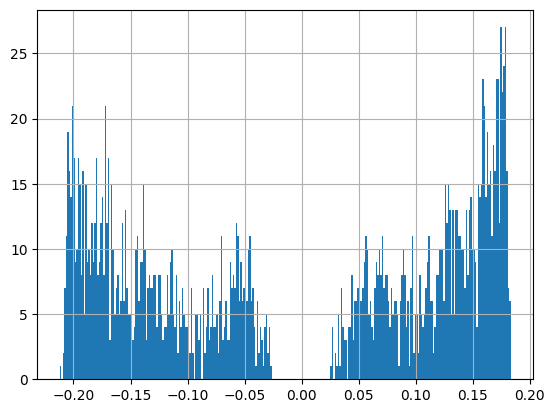

In [90]:
pd.Series(y_pred_val).hist(bins = 300)